In [7]:
import pandas as pd

df = pd.read_csv("../Data/telco_clean.csv")
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


(   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  Female              0     Yes         No       1           No   
 1    Male              0      No         No      34          Yes   
 2    Male              0      No         No       2          Yes   
 3    Male              0      No         No      45           No   
 4  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity OnlineBackup  \
 0  No phone service             DSL             No          Yes   
 1                No             DSL            Yes           No   
 2                No             DSL            Yes          Yes   
 3  No phone service             DSL            Yes           No   
 4                No     Fiber optic             No           No   
 
   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
 0               No          No          No              No  Month-to-month   
 1              

In [8]:
X = df.drop(columns=["ChurnFlag"])
y = df["ChurnFlag"].astype(int)



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC-AUC: 0.838860471724922


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


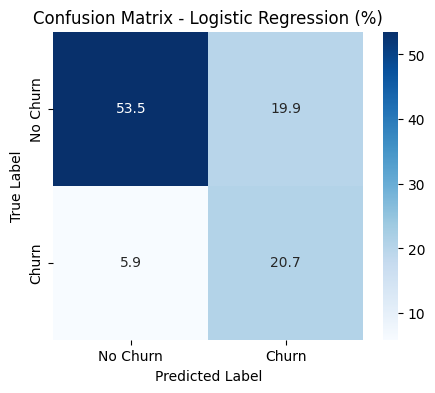

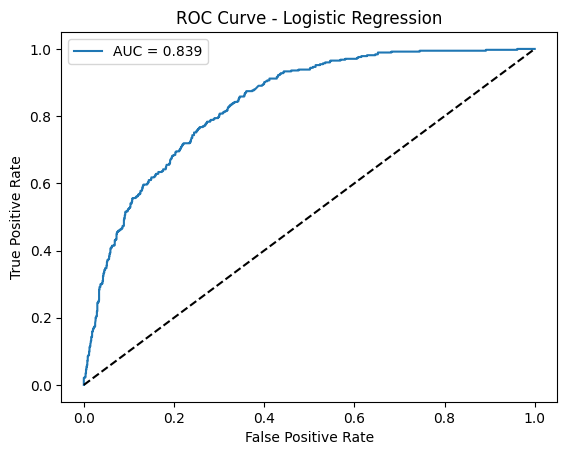

In [9]:
# MODELING NOTEBOOK SETUP 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# LOAD CLEAN DATA
df = pd.read_csv("../Data/telco_clean.csv")

# Separate features and target
X = df.drop(columns=["ChurnFlag"])
y = df["ChurnFlag"].astype(int)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# BUILD PREPROCESSING PIPELINE

# Numeric preprocessing: median imputation + scaling
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Categorical preprocessing: most_frequent imputation + one-hot encoding
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both into one ColumnTransformer
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# MODEL PIPELINE 
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")

model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", log_reg)
])

# TRAIN / TEST SPLIT 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TRAIN MODEL
model.fit(X_train, y_train)

# EVALUATE MODEL 
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# CONFUSION MATRIX (percent) 
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Logistic Regression (%)")
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.show()

# ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


In [11]:
from xgboost import XGBRegressor

clf = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:gender: object, Partner: object, Dependents: object, PhoneService: object, MultipleLines: object, InternetService: object, OnlineSecurity: object, OnlineBackup: object, DeviceProtection: object, TechSupport: object, StreamingTV: object, StreamingMovies: object, Contract: object, PaperlessBilling: object, PaymentMethod: object

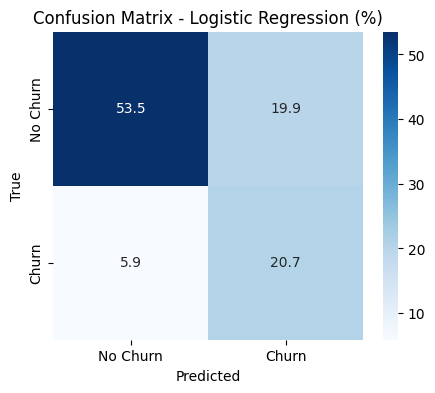

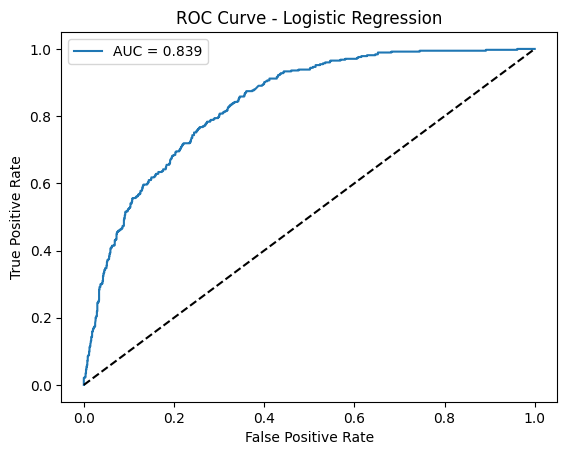

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100
plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Logistic Regression (%)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression"); plt.legend(); plt.show()


In [ ]:
param_grid = {
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"],
    "model__class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    clf,
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best ROC-AUC:", grid.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At le

Best Params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best ROC-AUC: 0.84436409504635


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)
y_prob = best_clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC (test): 0.8403769149293445


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:
import joblib
joblib.dump(best_clf, "churn_logreg_pipeline.pkl")
print("Saved model: churn_logreg_pipeline.pkl")


Saved model: churn_logreg_pipeline.pkl
